# Chapter III: Separable PINNs 

## Computational Efficiency
Numerical verification of SPINN computational costs from Section~\ref{sec:III1_SeparablePINNs}.

In [1]:
# Force CPU before importing JAX
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

import time
import numpy as np
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'grid'])

import deepxde as dde
import jax
import jax.numpy as jnp

print(f"JAX platform: {jax.devices()[0].platform}")

from phd.config import get_current_config, book_config
book_config.set_as_current()
page_width = get_current_config().page_width

results_folder = '../results/III_SeparablePINNs'
save_fig = True

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.

Enable just-in-time compilation with XLA.



JAX platform: cpu


In [2]:
# Network setup: larger architectures to minimize overhead impact
d, m, n_hidden, width, rank = 2, 2, 10, 64, 32

# SPINN: d body-networks (1D → r*m features)
spinn_layers = [d] + [width] * (n_hidden-1) + [rank] + [m]
spinn_net = dde.nn.SPINN(spinn_layers, "tanh", "Glorot uniform")
spinn_net.params = spinn_net.init(jax.random.PRNGKey(0), [jnp.ones((1,1)) for _ in range(d)])

# PFNN: m parallel subnetworks
pfnn_layers = [d] + [[width] * m] * n_hidden + [m]
pfnn_net = dde.nn.PFNN(pfnn_layers, "tanh", "Glorot uniform")
pfnn_net.params = pfnn_net.init(jax.random.PRNGKey(0), jnp.ones((1, d)))

count_params = lambda net: sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, net.params)))
print(f"Parameters - SPINN: {count_params(spinn_net):,}, PFNN: {count_params(pfnn_net):,}")

Parameters - SPINN: 75,136, PFNN: 75,394


### Forward Pass FLOPs

PFNN processes $N^d$ points → $\mathcal{O}(N^d)$. SPINN: $d$ body-networks on $N$ points + merging → between $\mathcal{O}(N)$ and $\mathcal{O}(N^d)$.

In [3]:
# FLOPs estimation on CPU (no subprocess needed since results are stable)
def estimate_flops_cpu(net_type, n, mode):
    """Estimate FLOPs on CPU with cache clearing."""
    jax.clear_caches()
    
    if net_type == "PFNN":
        X = jnp.ones((n**2, d))
        params = pfnn_net.params
        if mode == "forward":
            fn = lambda p, x: pfnn_net.apply(p, x)
        else:
            fn = lambda p, x: jax.vmap(lambda xi: jax.jacfwd(lambda xin: pfnn_net.apply(p, xin[None,:])[0])(xi))(x)
    else:
        X = [jnp.ones((n, 1)) for _ in range(d)]
        params = spinn_net.params
        if mode == "forward":
            fn = lambda p, x: spinn_net.apply(p, x)
        else:
            fn = lambda p, x: jax.jvp(lambda x1: spinn_net.apply(p, [x1, x[1]]), (x[0],), (jnp.ones_like(x[0]),))[1]
    
    return jax.jit(fn).lower(params, X).compile().cost_analysis()['flops']

batch_sizes = [8, 16, 32, 64, 128, 256, 512]
total_points = [n**2 for n in batch_sizes]

print("Computing FLOPs...", flush=True)

pfnn_fwd_flops, spinn_fwd_flops = [], []
pfnn_grad_flops, spinn_grad_flops = [], []

for n in batch_sizes:
    print(f"  N={n}...", end=" ", flush=True)
    pfnn_fwd_flops.append(estimate_flops_cpu("PFNN", n, "forward"))
    spinn_fwd_flops.append(estimate_flops_cpu("SPINN", n, "forward"))
    pfnn_grad_flops.append(estimate_flops_cpu("PFNN", n, "gradient"))
    spinn_grad_flops.append(estimate_flops_cpu("SPINN", n, "gradient"))

# Compute speedups
fwd_speedup = [p/s for p, s in zip(pfnn_fwd_flops, spinn_fwd_flops)]
grad_speedup = [p/s for p, s in zip(pfnn_grad_flops, spinn_grad_flops)]

Computing FLOPs...
  N=8...   N=8...   N=16...   N=16...   N=32...   N=32...   N=64...   N=64...   N=128...   N=128...   N=256...   N=256...   N=512...   N=512... 

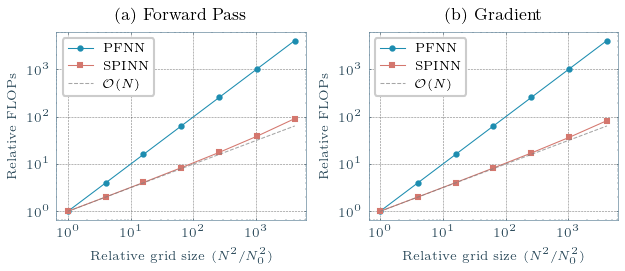

In [4]:
# Plot relative FLOPs scaling (2 subplots)
fig, axes = plt.subplots(1, 2, figsize=(page_width*0.9, page_width*0.4), dpi=150)

# Normalize to first point
pfnn_fwd_norm = np.array(pfnn_fwd_flops) / pfnn_fwd_flops[0]
spinn_fwd_norm = np.array(spinn_fwd_flops) / spinn_fwd_flops[0]
pfnn_grad_norm = np.array(pfnn_grad_flops) / pfnn_grad_flops[0]
spinn_grad_norm = np.array(spinn_grad_flops) / spinn_grad_flops[0]
pts_norm = np.array(total_points) / total_points[0]

# (a) Forward pass FLOPs
axes[0].loglog(pts_norm, pfnn_fwd_norm, 'o-', label='PFNN')
axes[0].loglog(pts_norm, spinn_fwd_norm, 's-', label='SPINN')
# axes[0].loglog(pts_norm, pts_norm, ':', label=r'$\mathcal{O}(N^2)$', color='gray', alpha=0.7)
axes[0].loglog(pts_norm, np.sqrt(pts_norm), '--', label=r'$\mathcal{O}(N)$', color='gray', alpha=0.7)
axes[0].set(xlabel=r'Relative grid size ($N^2/N_0^2$)', ylabel='Relative FLOPs', title='(a) Forward Pass')
axes[0].legend()

# (b) Gradient FLOPs
axes[1].loglog(pts_norm, pfnn_grad_norm, 'o-', label='PFNN')
axes[1].loglog(pts_norm, spinn_grad_norm, 's-', label='SPINN')
# axes[1].loglog(pts_norm, pts_norm, ':', label=r'$\mathcal{O}(N^2)$', color='gray', alpha=0.7)
axes[1].loglog(pts_norm, np.sqrt(pts_norm), '--', label=r'$\mathcal{O}(N)$', color='gray', alpha=0.7)
axes[1].set(xlabel=r'Relative grid size ($N^2/N_0^2$)', ylabel='Relative FLOPs', title='(b) Gradient')
axes[1].legend()

plt.tight_layout()

if save_fig:
    figure_dir = os.path.join(results_folder, "figures")
    os.makedirs(figure_dir, exist_ok=True)
    fig.savefig(os.path.join(figure_dir, "spinn_flops_scaling.pdf"), bbox_inches='tight')

In [5]:
# Gradient AD modes comparison at N=128
# Computing: d(u)/d(x_0) for all points (gradient w.r.t. first input dimension)

n = 512
n_pts = n**2
X_pfnn = jnp.ones((n_pts, d))
X_spinn = [jnp.ones((n, 1)) for _ in range(d)]

def get_flops(fn, X):
    jax.clear_caches()
    return jax.jit(fn).lower(X).compile().cost_analysis()['flops']

# PFNN: gradient w.r.t. first input dimension
def pfnn_forward_fn(x):
    return jax.vmap(lambda xi: jax.jacfwd(lambda xin: pfnn_net.apply(pfnn_net.params, xin[None,:])[0])(xi)[:, 0])(x)

def pfnn_backward_fn(x):
    return jax.vmap(lambda xi: jax.jacrev(lambda xin: pfnn_net.apply(pfnn_net.params, xin[None,:])[0])(xi)[:, 0])(x)

# SPINN: gradient w.r.t. x0 using jvp/vjp
def spinn_forward_fn(x):
    # jvp with tangent on x0 gives d(output)/d(x0) directly
    _, df = jax.jvp(lambda x0: spinn_net.apply(spinn_net.params, [x0, x[1]]), (x[0],), (jnp.ones_like(x[0]),))
    return df  # (N^2, m)

def spinn_backward_fn(x):
    # vjp for each output column - output is (N^2, m), cotangent should be (N^2,)
    def vjp_col(i):
        primals, vjp_fn = jax.vjp(lambda x0: spinn_net.apply(spinn_net.params, [x0, x[1]])[:, i], x[0])
        return vjp_fn(jnp.ones(n_pts))[0]  # (N^2,)
    return jnp.stack([vjp_col(i) for i in range(m)], axis=-1)  # (N^2, m)

# Compute all gradient FLOPs
results = {
    'PFNN backward': get_flops(pfnn_backward_fn, X_pfnn),
    'PFNN forward': get_flops(pfnn_forward_fn, X_pfnn),
    'SPINN backward': get_flops(spinn_backward_fn, X_spinn),
    'SPINN forward': get_flops(spinn_forward_fn, X_spinn),
}

pfnn_backward = results['PFNN backward']

print(f"Gradient FLOPs at N={n} ({n_pts:,} points), d={d} inputs, m={m} outputs")
print("Computing: d(u)/d(x_0) for all points")
print("=" * 60)
print(f"{'Method':<20} {'FLOPs':>15} {'Speedup':>15}")
print("-" * 60)
for name, flops in results.items():
    speedup = pfnn_backward / flops
    print(f"{name:<20} {flops:>15.2e} {speedup:>14.1f}x")
print("-" * 60)

print(f"\nKey observations:")
print(f"  SPINN forward (jvp) vs PFNN backward: {pfnn_backward/results['SPINN forward']:.1f}x speedup")
print(f"  SPINN backward (vjp) vs SPINN forward (jvp): {results['SPINN backward']/results['SPINN forward']:.1f}x")

Gradient FLOPs at N=512 (262,144 points), d=2 inputs, m=2 outputs
Computing: d(u)/d(x_0) for all points
Method                         FLOPs         Speedup
------------------------------------------------------------
PFNN backward               1.19e+11            1.0x
PFNN forward                1.19e+11            1.0x
SPINN backward              2.17e+08          548.3x
SPINN forward               1.44e+08          825.3x
------------------------------------------------------------

Key observations:
  SPINN forward (jvp) vs PFNN backward: 825.3x speedup
  SPINN backward (vjp) vs SPINN forward (jvp): 1.5x


In [9]:
# Reliable GPU timing comparison
from functools import partial
import subprocess
import sys
import gc

# Clear all caches before running
jax.clear_caches()
gc.collect()

# Run timing in subprocess with GPU - completely isolated environment
timing_script = '''
import os
# Force fresh CUDA context
os.environ['JAX_PLATFORMS'] = 'cuda'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'  # Don't preallocate GPU memory

import time
import numpy as np
import jax
import jax.numpy as jnp
import deepxde as dde
from functools import partial

# Clear any existing caches at start
jax.clear_caches()

print(f"Timing platform: {jax.devices()[0].platform}", flush=True)

# Network setup - must match main notebook
d, m, n_hidden, width, rank = 2, 2, 10, 64, 32

spinn_layers = [d] + [width] * (n_hidden-1) + [rank] + [m]
spinn_net = dde.nn.SPINN(spinn_layers, "tanh", "Glorot uniform")
spinn_net.params = spinn_net.init(jax.random.PRNGKey(0), [jnp.ones((1,1)) for _ in range(d)])

pfnn_layers = [d] + [[width] * m] * n_hidden + [m]
pfnn_net = dde.nn.PFNN(pfnn_layers, "tanh", "Glorot uniform")
pfnn_net.params = pfnn_net.init(jax.random.PRNGKey(0), jnp.ones((1, d)))

def time_compiled(compiled_fn, runs=100):
    """Reliable GPU timing with proper synchronization."""
    # Warm up GPU (wake from power-saving mode)
    for _ in range(20):
        jax.block_until_ready(compiled_fn())
    
    times = []
    for _ in range(runs):
        start = time.perf_counter()
        result = compiled_fn()
        jax.block_until_ready(result)
        times.append(time.perf_counter() - start)
    
    # Use median of middle 80% to remove outliers
    times = sorted(times)
    n = len(times)
    trimmed = times[n//10 : 9*n//10]
    return np.median(trimmed) * 1000  # ms

def pfnn_forward(params, x):
    return pfnn_net.apply(params, x)

def pfnn_grad(params, x):
    return jax.vmap(lambda xi: jax.jacrev(lambda xin: pfnn_net.apply(params, xin[None,:])[0])(xi))(x)

def spinn_forward(params, x):
    return spinn_net.apply(params, x)

def spinn_grad(params, x):
    _, df = jax.jvp(lambda x0: spinn_net.apply(params, [x0, x[1]]), (x[0],), (jnp.ones_like(x[0]),))
    return df

timing_batch_sizes = [8, 16, 32, 64, 128, 256, 512]

pfnn_fwd_times, spinn_fwd_times = [], []
pfnn_grad_times, spinn_grad_times = [], []

# Warm up GPU with dummy computation
dummy = jnp.ones((1000, 1000)) @ jnp.ones((1000, 1000))
jax.block_until_ready(dummy)
del dummy

for n in timing_batch_sizes:
    print(f"N={n}", end=" ", flush=True)
    
    # Clear caches for each batch size
    jax.clear_caches()
    
    X_p = jnp.ones((n**2, d))
    X_s = [jnp.ones((n, 1)) for _ in range(d)]
    
    # Compile functions
    pfnn_fwd_compiled = jax.jit(partial(pfnn_forward, pfnn_net.params, X_p)).lower().compile()
    spinn_fwd_compiled = jax.jit(partial(spinn_forward, spinn_net.params, X_s)).lower().compile()
    pfnn_grad_compiled = jax.jit(partial(pfnn_grad, pfnn_net.params, X_p)).lower().compile()
    spinn_grad_compiled = jax.jit(partial(spinn_grad, spinn_net.params, X_s)).lower().compile()
    
    # Time each function
    pfnn_fwd_times.append(time_compiled(pfnn_fwd_compiled))
    spinn_fwd_times.append(time_compiled(spinn_fwd_compiled))
    pfnn_grad_times.append(time_compiled(pfnn_grad_compiled))
    spinn_grad_times.append(time_compiled(spinn_grad_compiled))

# Print results as CSV
print()
for i in range(len(timing_batch_sizes)):
    print(f"{pfnn_fwd_times[i]:.6f},{spinn_fwd_times[i]:.6f},{pfnn_grad_times[i]:.6f},{spinn_grad_times[i]:.6f}")
'''

# Run in a completely fresh Python process
env = os.environ.copy()
env['JAX_PLATFORMS'] = 'cuda'
env['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

result = subprocess.run(
    [sys.executable, '-c', timing_script], 
    capture_output=True, 
    text=True,
    env=env
)
print(result.stdout)
if result.stderr:
    stderr_lines = [l for l in result.stderr.split('\n') if 'error' in l.lower() or 'Error' in l]
    if stderr_lines:
        print("Errors:", '\n'.join(stderr_lines[:5]))

# Parse results
lines = result.stdout.strip().split('\n')
data_lines = [l for l in lines if ',' in l and l.count(',') == 3]

timing_batch_sizes = [8, 16, 32, 64, 128, 256, 512]
pfnn_fwd_times, spinn_fwd_times = [], []
pfnn_grad_times, spinn_grad_times = [], []

for line in data_lines:
    pf, sf, pg, sg = map(float, line.split(','))
    pfnn_fwd_times.append(pf)
    spinn_fwd_times.append(sf)
    pfnn_grad_times.append(pg)
    spinn_grad_times.append(sg)

# Compute time speedups
time_fwd_speedup = [p/s for p, s in zip(pfnn_fwd_times, spinn_fwd_times)]
time_grad_speedup = [p/s for p, s in zip(pfnn_grad_times, spinn_grad_times)]

print("\nGPU Timing complete.")

Timing platform: gpu
N=8 N=16 N=32 N=64 N=128 N=256 N=512 
0.216522,0.206144,1.312749,1.262423
1.225434,1.222919,1.292272,1.276012
1.283306,1.280275,1.345935,1.266344
1.218970,1.265289,2.332115,1.227720
1.275970,1.244161,1.352717,1.216061
1.221918,1.224166,3.437157,1.223919
0.262509,1.249305,20.588083,1.252757


GPU Timing complete.



LaTeX table saved to: ../results/III_SeparablePINNs/table/spinn_efficiency_table.tex

At N=512 (262,144 points):
  FLOPs speedup  - Forward: 356.8x, Gradient: 822.9x
  Time speedup   - Forward: 0.2x, Gradient: 16.4x

At N=512 (262,144 points):
  FLOPs speedup  - Forward: 356.8x, Gradient: 822.9x
  Time speedup   - Forward: 0.2x, Gradient: 16.4x


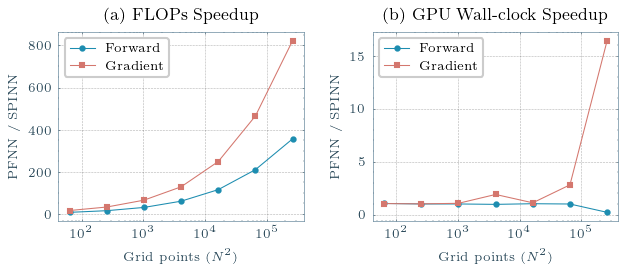

In [11]:
# Generate comprehensive LaTeX table, display as table, and save to disk
from IPython.display import display, Markdown
import pandas as pd

timing_total_points = [n**2 for n in timing_batch_sizes]

# Create DataFrame for display - reorganized with Forward/Gradient as main sections
# Merged format: "FLOPs / time ms (speedup)"
fwd_data = []
for i, n in enumerate(timing_batch_sizes):
    fwd_data.append({
        'N': n,
        'PFNN (FLOPs / ms)': f"{pfnn_fwd_flops[i]:.2e} / {pfnn_fwd_times[i]:.3f}",
        'SPINN (FLOPs / ms)': f"{spinn_fwd_flops[i]:.2e} / {spinn_fwd_times[i]:.3f}",
        'Speedup (FLOPs / Time)': f"{fwd_speedup[i]:.1f}× / {time_fwd_speedup[i]:.1f}×"
    })

grad_data = []
for i, n in enumerate(timing_batch_sizes):
    grad_data.append({
        'N': n,
        'PFNN (FLOPs / ms)': f"{pfnn_grad_flops[i]:.2e} / {pfnn_grad_times[i]:.3f}",
        'SPINN (FLOPs / ms)': f"{spinn_grad_flops[i]:.2e} / {spinn_grad_times[i]:.3f}",
        'Speedup (FLOPs / Time)': f"{grad_speedup[i]:.1f}× / {time_grad_speedup[i]:.1f}×"
    })

# LaTeX table with two big sections: Forward and Gradient
# Merged columns: FLOPs/time and speedup (FLOPs/Time) in each cell
latex_table = r"""\begin{tabular}{lrrr}
    \toprule
    & \multicolumn{2}{c}{\textbf{FLOPs / Time (ms)}} & \textbf{Speedup} \\
    \cmidrule(lr){2-3}
    $N$ & PFNN & SPINN & (FLOPs / Time) \\
    \midrule
    \multicolumn{4}{c}{\textit{Forward Pass}} \\
    \midrule
"""
for i, n in enumerate(timing_batch_sizes):
    latex_table += f"    {n} & {pfnn_fwd_flops[i]:.2e} / {pfnn_fwd_times[i]:.3f} "
    latex_table += f"& {spinn_fwd_flops[i]:.2e} / {spinn_fwd_times[i]:.3f} "
    latex_table += f"& {fwd_speedup[i]:.1f}$\\times$ / {time_fwd_speedup[i]:.1f}$\\times$ \\\\\n"

latex_table += r"""    \midrule
    \multicolumn{4}{c}{\textit{Gradient}} \\
    \midrule
"""
for i, n in enumerate(timing_batch_sizes):
    latex_table += f"    {n} & {pfnn_grad_flops[i]:.2e} / {pfnn_grad_times[i]:.3f} "
    latex_table += f"& {spinn_grad_flops[i]:.2e} / {spinn_grad_times[i]:.3f} "
    latex_table += f"& {grad_speedup[i]:.1f}$\\times$ / {time_grad_speedup[i]:.1f}$\\times$ \\\\\n"

latex_table += r"""    \bottomrule
\end{tabular}"""

# Save LaTeX table to disk
table_dir = os.path.join(results_folder, "table")
os.makedirs(table_dir, exist_ok=True)
latex_path = os.path.join(table_dir, "spinn_efficiency_table.tex")
with open(latex_path, 'w') as f:
    f.write(latex_table)
print(f"\nLaTeX table saved to: {latex_path}")

# Plot: FLOPs speedup vs Time speedup
fig, axes = plt.subplots(1, 2, figsize=(page_width*0.9, page_width*0.4), dpi=150)

# (a) FLOPs Speedup
axes[0].semilogx(timing_total_points, fwd_speedup, 'o-', label='Forward')
axes[0].semilogx(timing_total_points, grad_speedup, 's-', label='Gradient')
axes[0].set(xlabel=r'Grid points ($N^2$)', ylabel=r'PFNN / SPINN', title='(a) FLOPs Speedup')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# (b) Time Speedup (GPU)
axes[1].semilogx(timing_total_points, time_fwd_speedup, 'o-', label='Forward')
axes[1].semilogx(timing_total_points, time_grad_speedup, 's-', label='Gradient')
axes[1].set(xlabel=r'Grid points ($N^2$)', ylabel=r'PFNN / SPINN', title='(b) GPU Wall-clock Speedup')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

if save_fig:
    figure_dir = os.path.join(results_folder, "figures")
    os.makedirs(figure_dir, exist_ok=True)
    fig.savefig(os.path.join(figure_dir,"spinn_speedup_comparison.pdf"), bbox_inches='tight')

print(f"\nAt N={timing_batch_sizes[-1]} ({timing_total_points[-1]:,} points):")
print(f"  FLOPs speedup  - Forward: {fwd_speedup[-1]:.1f}x, Gradient: {grad_speedup[-1]:.1f}x")
print(f"  Time speedup   - Forward: {time_fwd_speedup[-1]:.1f}x, Gradient: {time_grad_speedup[-1]:.1f}x")